# Computer Vision - Project
imports

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import h5py
import requests
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
import tensorflow as tf
import h5py, requests, os
import matplotlib.patches as patches
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten, BatchNormalization, ZeroPadding2D, GlobalMaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers import LSTM
from keras.layers import Resizing
from tqdm import tqdm
from pathlib import Path
import splitfolders
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import callbacks
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GaussianNoise
from keras import regularizers
from download_h5py_db import download_h5py_db
from sklearn.metrics import classification_report

Constants

In [2]:
#ZIP_PATH = "https://drive.google.com/drive/folders/1jzHYpTwywUYA53nMGHVROSuVO14hEueq?usp=sharing/"
FILE_NAME ="SynthText_train.h5"
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)
tf.keras.backend.clear_session()
SIZE=224
db = h5py.File(FILE_NAME, 'r')
main_directory='main_directory'
main_directory_splitted='main_directory_splitted'


In [3]:
def sort_points(points, center):
    # calculate the angle of each point from the center point
    angles = np.arctan2(points[:, 1] - center[1], points[:, 0] - center[0])
    # sort the points by angle
    sorted_points = points[np.argsort(angles)]
    return sorted_points

In [4]:
def draw_training_curve(history):
	"""
	Draw training curve
	Parameters:
		history - contains loss and accuracy from training
	Returns:
		None
	"""
	plt.figure(1)

	# History for accuracy
	plt.subplot(211)
	plt.plot(history.history['accuracy'])
	plt.plot(history.history['val_accuracy'])
	plt.title('model accuracy')
	plt.ylabel('accuracy')
	plt.xlabel('epoch')
	plt.legend(['train', 'test'], loc='upper left')

	# History for loss
	plt.subplot(212)
	plt.plot(history.history['loss'])
	plt.plot(history.history['val_loss'])
	plt.title('model loss')
	plt.ylabel('loss')
	plt.xlabel('epoch')
	plt.legend(['train', 'test'], loc='upper left')

	plt.show()

In [5]:
def draw_points(image, points, color=(255, 0, 0), radius=3):
    # create a copy of the image
    img = image.copy()
    # iterate over the points and draw them on the image
    for point in points:
        cv2.circle(img, tuple(map(int, point)), radius, color, -1)
    return img


In [6]:
def font_to_num(font):
    if font == b'Alex Brush':
        return 0
    elif font == b'Open Sans':
        return 1
    elif font == b'Sansation':
        return 2
    elif font == b'Titillium Web':
        return 3
    else:
        return 4

In [7]:
def num_to_font(font):
    if font == 0:
        return b'Alex Brush'
    elif font == 1:
        return b'Open Sans'
    elif font == 2:
        return b'Sansation'
    elif font == 3:
        return b'Titillium Web'
    else:
        return b'Ubuntu Mono'

In [8]:

def prepare_img(img, bbs, index, size = SIZE):
    x1 = int(bbs[0,0,index])
    y1 = int(bbs[1,0,index])
    x2 = int(bbs[0,1,index])
    y2 = int(bbs[1,1,index])
    x3 = int(bbs[0,2,index])
    y3 = int(bbs[1,2,index])
    x4 = int(bbs[0,3,index])
    y4 = int(bbs[1,3,index])
    # calculate bounding rectangle
    top_left_x = max(0, min([x1,x2,x3,x4]))
    top_left_y = max(0, min([y1,y2,y3,y4]))
    bot_right_x = max(0, max([x1,x2,x3,x4]))
    bot_right_y = max(0, max([y1,y2,y3,y4]))

    cropped = img[top_left_y:bot_right_y+1, top_left_x:bot_right_x+1]
    # _, cropped = cv2.threshold(cropped,127,255,cv2.THRESH_TRIANGLE)
    # print(cropped.shape)
    cropped = tf.image.resize(cropped, (size, size), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    # cropped = tf.image.rgb_to_grayscale(cropped)
    # # print(cropped.shape)
    cropped = tf.image.convert_image_dtype(cropped, tf.float32)
    # plt.imshow(cropped, cmap='gray')
    # plt.show()
    return cropped

In [9]:

def create_dirs(main_dir):
    Path(main_dir).mkdir(parents=True, exist_ok=True)
    Path(main_dir+'/Alex Brush').mkdir(parents=True, exist_ok=True)
    Path(main_dir+'/Titillium Web').mkdir(parents=True, exist_ok=True)
    Path(main_dir+'/Sansation').mkdir(parents=True, exist_ok=True)
    Path(main_dir+'/Open Sans').mkdir(parents=True, exist_ok=True)
    Path(main_dir+'/Ubuntu Mono').mkdir(parents=True, exist_ok=True)

In [10]:
def get_image_data(db, im):
    img  = db['data'][im][:]
    fonts = db['data'][im].attrs['font']
    txts = db['data'][im].attrs['txt']
    charBBs = db['data'][im].attrs['charBB']
    wordBBs = db['data'][im].attrs['wordBB']
    return img, fonts, txts, charBBs, wordBBs

In [11]:
def is_num_or_letter(inp):
    res= ((inp >= ord('a') and inp <= ord('z')) or (inp >= ord('A') and inp <= ord('Z'))) or (inp>=ord('0') and inp<=ord('9'))
    # print(chr(inp)+"="+str(res))
    return res

In [12]:
def crop_and_save(img, BBs, indx, size, curr_font, im, num, append_not_save=False, folder='main_directory/'):
    cropped = prepare_img(img, BBs, indx, size)
    path = folder+curr_font.decode('UTF-8')+'/'+im+'_'+str(num)+'.png' 
    if not append_not_save:
        tf.keras.utils.save_img(path,cropped)
    return cropped

In [13]:
def get_data_set(db, size: int):   
    create_dirs(main_directory)
    im_names = list(db['data'].keys())
    num = 0
    for i in tqdm(range(0, len(im_names)-1)):
        im = im_names[i]
        img, fonts, txts, charBBs, wordBBs = get_image_data(db, im)
        font_indx = 0 
        char_indx = 0
        # print(im)
        for j in range(0, len(txts)):
            cropped = prepare_img(img, wordBBs, j, size)
            path = main_directory+'/'+fonts[font_indx].decode('UTF-8')+'/'+im+'_'+str(num)+'.png' 
            # print(path)
            tf.keras.utils.save_img(path,cropped)
            num+=1
            # train_x.append(cropped)
            # train_y.append(font_to_num(fonts[font_indx]))
            
            # plt.imshow(cropped, cmap='gray')
            # plt.show()
            # print(fonts[font_indx])
            for k in range(0, len(txts[j])):
                if(is_num_or_letter(txts[j][k])):
                    cropped = prepare_img(img, charBBs, char_indx, size)
                    path = main_directory+'/'+fonts[font_indx].decode('UTF-8')+'/'+im+'_'+str(num)+'.png'
                    # print(path)
                    tf.keras.utils.save_img(path,cropped)
                    num+=1
                    # train_x.append(cropped)
                    # train_y.append(font_to_num(fonts[font_indx]))
                char_indx+=1
                    # plt.imshow(cropped, cmap='gray')
                    # plt.show()
                    # print(fonts[font_indx])
            font_indx += len(txts[j])
    print(num)

In [14]:

if not Path(main_directory).exists():
    download_h5py_db()
    get_data_set(db, SIZE)


In [ ]:

if not Path(main_directory_splitted).exists():
    splitfolders.ratio(main_directory, # The location of dataset
                    output=main_directory_splitted, # The output location
                    seed=42, # The number of seed
                    ratio=(.8, .1, .1), # The ratio of splited dataset
                    group_prefix=None, # If your dataset contains more than one file like ".jpg", ".pdf", etc
                    move=False # If you choose to move, turn this into True
                    )

Copying files: 1950 files [00:03, 788.88 files/s]

KeyboardInterrupt: 

Copying files: 2008 files [00:23, 788.88 files/s]

In [ ]:

def data_augmentation():
    datagen =  ImageDataGenerator(
        horizontal_flip=True, rotation_range=90, fill_mode='reflect', channel_shift_range=0.8,#
         shear_range=15,vertical_flip=False, brightness_range=(0.2, 0.8),# 
     rescale=1/255, dtype='float32'
     #,validation_split=0.25
     )
    # Path('augmented').mkdir(exist_ok=True)
    it = datagen.flow_from_directory(main_directory_splitted+'/train/', batch_size=18, class_mode='categorical', target_size=(SIZE,SIZE),
    #save_to_dir='augmented',
     shuffle=True, seed=1, keep_aspect_ratio=True)
    datagen_val =  ImageDataGenerator(
     rescale=1/255, dtype='float32'
     )
    val_it = datagen_val.flow_from_directory(main_directory_splitted+'/val/', batch_size=18, class_mode='categorical',  target_size=(SIZE,SIZE),
    #save_to_dir='augmented',
     shuffle=True)
    test_it = datagen_val.flow_from_directory(main_directory_splitted+'/test/', batch_size=18, class_mode='categorical',  target_size=(SIZE,SIZE),
    #save_to_dir='augmented',
     shuffle=True)
    return it, val_it,test_it, datagen

In [ ]:
it, val_it,test_it, datagen = data_augmentation()

Found 28806 images belonging to 5 classes.
Found 3599 images belonging to 5 classes.
Found 3606 images belonging to 5 classes.


In [ ]:

early_stopping=callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min')

filepath="res/top_model2.h5"

checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

callbacks_list = [early_stopping,checkpoint]

In [ ]:


num_classes = 5
input_size= SIZE

baseModel = tf.keras.applications.ResNet50(include_top=False, classes=num_classes,
                         input_shape=(input_size, input_size, 3),
                        weights='imagenet')
headModel = baseModel.output
headModel = GaussianNoise(0.1)(headModel)
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.01))(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(num_classes, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)    
model.compile(optimizer=tf.keras.optimizers.Adam(0.00003), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# model.fit(X_train, Y_train, batch_size=16, epochs=20)
# datagen.fit(X_train)
# if not os.path.isfile('model_res.h5'):
history = model.fit(it, epochs=30, shuffle=True, validation_data=val_it, verbose=1
            ,callbacks=callbacks_list
            )
# else:
#   model = tf.keras.models.load_model('model_res.h5')

Epoch 1/30
1601/1601 [==============================] - ETA: 0s - loss: 5.6927 - accuracy: 0.3746
Epoch 1: val_loss did not improve from 1.98395
1601/1601 [==============================] - 462s 284ms/step - loss: 5.6927 - accuracy: 0.3746 - val_loss: 4.8919 - val_accuracy: 0.5107
Epoch 2/30
1601/1601 [==============================] - ETA: 0s - loss: 4.2406 - accuracy: 0.5411
Epoch 2: val_loss did not improve from 1.98395
1601/1601 [==============================] - 413s 258ms/step - loss: 4.2406 - accuracy: 0.5411 - val_loss: 3.5724 - val_accuracy: 0.5929
Epoch 3/30
1601/1601 [==============================] - ETA: 0s - loss: 3.0651 - accuracy: 0.6111
Epoch 3: val_loss did not improve from 1.98395
1601/1601 [==============================] - 417s 260ms/step - loss: 3.0651 - accuracy: 0.6111 - val_loss: 2.5281 - val_accuracy: 0.6491
Epoch 4/30
1601/1601 [==============================] - ETA: 0s - loss: 2.1996 - accuracy: 0.6613
Epoch 4: val_loss improved from 1.98395 to 1.84768, savi

In [ ]:
score = model.evaluate(test_it)

201/201 [==============================] - 18s 87ms/step - loss: 0.4904 - accuracy: 0.8336


In [ ]:
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 0.49044957756996155 / Test accuracy: 0.8336106538772583


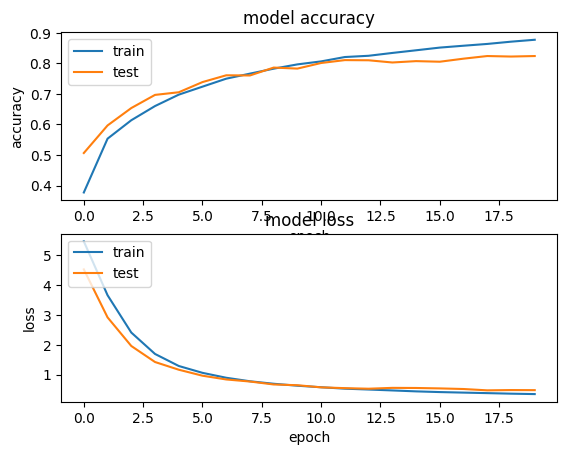

In [ ]:
draw_training_curve(history)

In [ ]:
model = tf.keras.models.load_model('res//top_model2.h5')

In [ ]:
model.evaluate(test_it)

201/201 [==============================] - 25s 74ms/step - loss: 0.5045 - accuracy: 0.8272


[0.5045388340950012, 0.8272323608398438]

In [ ]:
from sklearn.preprocessing import normalize
create_dirs('test_set')
size=SIZE
im_names = list(db['data'].keys())
num = 0
prediction_arr=[]
test_y = []
# test_x_total = []
# test_y_total = []
for i in tqdm(range(int(len(im_names)/3), int(len(im_names)/1.5))):
    im = im_names[i]
    img, fonts, txts, charBBs, wordBBs = get_image_data(db, im)
    font_indx = 0 
    char_indx = 0
    
    # print(im)
    for j in range(0, len(txts)):
        if(j%8==0): 
            curr_font = fonts[font_indx]
            test_x = [] 
            cropped = crop_and_save(img, wordBBs, j, size, curr_font, im, num, False, 'test_set/')
            test_x.append(cropped)
            # test_x_total.append(cropped)
            # test_y_total.append(font_to_num(curr_font))
            # test_y.append(font_to_num(curr_font))
            num+=1            
            for k in range(0, len(txts[j])):
                # if(is_num_or_letter(txts[j][k])):
                cropped = crop_and_save(img, charBBs, char_indx, size, curr_font, im, num, False, 'test_set/')
                test_x.append(cropped)
                # test_x_total.append(cropped)
                # test_y_total.append(font_to_num(curr_font))
                    # test_y.append(font_to_num(curr_font))
                num+=1
                char_indx+=1
            test_x = np.asarray(test_x, dtype=np.float32)
            # # print(test_x)
            reses = model.predict(test_x, verbose=0)
            # # print(reses)
            maxes = np.argmax(reses, axis=1)
            # print(np.bincount(maxes))
            prediction = np.bincount(maxes)
            prediction = np.argwhere(prediction==prediction.max())
            if (len(prediction)>1):
                sum_p = reses.sum(axis=0)
                prediction = sum_p.argmax()

                if(font_to_num(curr_font)!=prediction):
                    # print(sum_p)
                    reses_n = normalize(reses, axis=1, norm='l1')
                    maxes_n = np.argmax(reses_n, axis=1)
                    # print(np.bincount(maxes))
                    prediction = np.bincount(maxes_n)
                    prediction = np.argmax(prediction)
                    if(font_to_num(curr_font)!=prediction):
                        sum_p = np.sum(reses, axis=0)
                        prediction = sum_p.argmax()
                    # # print(reses[0]/np.sum(reses, axis=1)[0])
                    #     print(maxes)
                    # print(prediction)
                    # plt.imshow(test_x[0])
                    # plt.show()
                    # print(prediction)
                    # print(font_to_num(fonts[font_indx]))
            for k in range(0, len(txts[j])):
                test_y.append(font_to_num(fonts[font_indx]))
                prediction_arr.append(prediction.item())
                # print(prediction.item())
            # if(font_to_num(curr_font)!=prediction):
            #     plt.imshow(test_x[0])
            #     plt.show()
            #     print(maxes)
            #     print(reses)
            #     print(prediction)
            #     print(font_to_num(fonts[font_indx]))
            #     print('----------------------')
            # print(num_to_font(prediction))
            # print(test_x)
            # print(str(np.bincount(maxes).argmax())+"-"+str(font_to_num(fonts[font_indx])))
            # print(np.bincount(maxes).argmax())
        else:
            char_indx+=len(txts[j])
        font_indx += len(txts[j])



100%|██████████| 333/333 [00:56<00:00,  5.94it/s]


Check with arrays per image

In [ ]:
print(len(prediction_arr))
print(len(test_y))

1953
1953


In [ ]:
y_pred=np.argmax(prediction_arr, axis=1)

In [ ]:

labels=['Alex Brush','Open Sans','Sansation','Titillium Web','Ubuntu Mono']
print(classification_report(test_y, prediction_arr, target_names=labels))

               precision    recall  f1-score   support

   Alex Brush       0.97      1.00      0.99       414
    Open Sans       0.92      0.93      0.93       328
    Sansation       0.94      0.94      0.94       418
Titillium Web       0.97      0.90      0.94       366
  Ubuntu Mono       0.97      0.99      0.98       427

     accuracy                           0.96      1953
    macro avg       0.96      0.95      0.95      1953
 weighted avg       0.96      0.96      0.96      1953



Check with one big array

In [ ]:
test_x_total = np.asanyarray(test_x_total, np.float32)

In [ ]:
test_y_cat = np_utils.to_categorical(test_y_total, 5)

In [ ]:
model.evaluate(test_x_total,test_y_cat)

77/77 [==============================] - 8s 105ms/step - loss: 1.5614 - accuracy: 0.8484


[1.5614203214645386, 0.8483606576919556]

In [ ]:
pred_y_total = model.predict(test_x_total)

37/37 [==============================] - 5s 101ms/step


In [ ]:
pred_y_total=np.argmax(pred_y_total, axis=1)


In [ ]:
from sklearn.metrics import classification_report
labels=['Alex Brush','Open Sans','Sansation','Titillium Web','Ubuntu Mono']
print(classification_report(test_y_total, pred_y_total, target_names=labels))

               precision    recall  f1-score   support

   Alex Brush       0.89      0.94      0.92       215
    Open Sans       0.86      0.72      0.78       210
    Sansation       0.81      0.85      0.83       254
Titillium Web       0.87      0.81      0.84       254
  Ubuntu Mono       0.83      0.93      0.88       230

     accuracy                           0.85      1163
    macro avg       0.85      0.85      0.85      1163
 weighted avg       0.85      0.85      0.85      1163



Check with flow from test directory

In [ ]:
dg =  ImageDataGenerator(
     rescale=1/255, dtype='float32'
     )
t_dir = dg.flow_from_directory('test_set', shuffle=False,target_size=(SIZE,SIZE))

Found 4 images belonging to 5 classes.


In [ ]:
model.evaluate(t_dir)

1/1 [==============================] - 0s 254ms/step - loss: 1.0607 - accuracy: 0.5000


[1.060684084892273, 0.5]

In [ ]:
r = model.predict(t_dir)

1/1 [==============================] - 0s 104ms/step


In [ ]:
y_p=np.argmax(r, axis=1)

In [ ]:
print(classification_report(y_p, t.classes, target_names=labels))

ValueError: Found input variables with inconsistent numbers of samples: [13, 8]

Check with flow from one big array

In [ ]:
test_y_cat = np_utils.to_categorical(test_y_total, 5)

In [ ]:
dg2 =  ImageDataGenerator(
     dtype='float32'
     )
t2_arr = dg2.flow(test_x_total,test_y_cat, shuffle=False,target_size=(SIZE,SIZE))

In [ ]:
score = model.evaluate(t2_arr)

1/1 [==============================] - 0s 212ms/step - loss: 1.7281 - accuracy: 0.2500


In [ ]:
p2 = model.predict(t2_arr)

1/1 [==============================] - 0s 73ms/step


In [ ]:
# get the class with highest probability for each sample
y_p2 = np.argmax(p2, axis=-1)

In [ ]:
print(classification_report(y_p2, test_y_total, target_names=labels))

               precision    recall  f1-score   support

   Alex Brush       0.00      0.00      0.00         3
    Open Sans       0.00      0.00      0.00         1
    Sansation       0.40      0.40      0.40         5
Titillium Web       0.38      1.00      0.55         3
  Ubuntu Mono       0.00      0.00      0.00         1

     accuracy                           0.38        13
    macro avg       0.15      0.28      0.19        13
 weighted avg       0.24      0.38      0.28        13



c:\Users\simon\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\simon\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\simon\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Cehck dir from array

In [ ]:
path=('test_set/')
create_dirs(path)
for i,imi in enumerate(test_x_total):
    tf.keras.utils.save_img(path+'/'+num_to_font(test_y_total[i]).decode('UTF-8')+'/'+str(i)+'.jpg',imi)

In [ ]:
dg3 =  ImageDataGenerator(
     rescale=1/255, dtype='float32'
     )
t3 = dg3.flow_from_directory('test_set/', shuffle=False, target_size=(SIZE,SIZE))

Found 8 images belonging to 5 classes.


In [ ]:
model.evaluate(t3)

1/1 [==============================] - 0s 300ms/step - loss: 1.0444 - accuracy: 0.5000


[1.0443546772003174, 0.5]

In [ ]:
# prediction_arr_cat = np_utils.to_categorical(prediction_arr, 5)
# test_y_cat = np_utils.to_categorical(test_y, 5)

In [ ]:
# import tensorflow as tf

# m = tf.keras.metrics.AUC()

# m.update_state(test_y, prediction_arr) # assuming both have shape (N,)

# r = m.result().numpy()

# print(r)

In [ ]:
# y_true = test_y_cat
# y_pred = prediction_arr
# kacc = tf.keras.metrics.Accuracy()
# _ = kacc.update_state(y_true, y_pred)
# print(f'Keras Accuracy acc: {kacc.result().numpy()*100:.3}')

# kbacc = tf.keras.metrics.BinaryAccuracy()
# _ = kbacc.update_state(y_true, y_pred)
# print(f'Keras BinaryAccuracy acc: {kbacc.result().numpy()*100:.3}')

# print(f'SkLearn acc: {accuracy_score(y_true, y_pred)*100:.3}')

[[[0.5647059  0.3647059  0.25882354]
  [0.5647059  0.3647059  0.25882354]
  [0.5647059  0.3647059  0.25882354]
  ...
  [0.5686275  0.3921569  0.29803923]
  [0.5686275  0.3921569  0.29803923]
  [0.5686275  0.3921569  0.29803923]]

 [[0.5647059  0.3647059  0.25882354]
  [0.5647059  0.3647059  0.25882354]
  [0.5647059  0.3647059  0.25882354]
  ...
  [0.5686275  0.3921569  0.29803923]
  [0.5686275  0.3921569  0.29803923]
  [0.5686275  0.3921569  0.29803923]]

 [[0.5647059  0.3647059  0.25882354]
  [0.5647059  0.3647059  0.25882354]
  [0.5647059  0.3647059  0.25882354]
  ...
  [0.5686275  0.3921569  0.29803923]
  [0.5686275  0.3921569  0.29803923]
  [0.5686275  0.3921569  0.29803923]]

 ...

 [[0.5568628  0.3803922  0.25882354]
  [0.5568628  0.3803922  0.25882354]
  [0.5568628  0.3803922  0.25882354]
  ...
  [0.7294118  0.6392157  0.59607846]
  [0.7294118  0.6392157  0.59607846]
  [0.7294118  0.6392157  0.59607846]]

 [[0.5568628  0.3803922  0.25882354]
  [0.5568628  0.3803922  0.25882354]


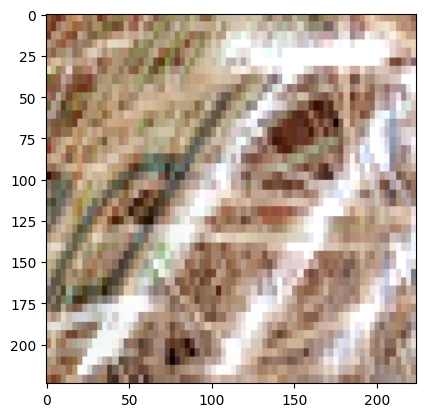

In [ ]:
h = t2_arr.next()[0][1]
print(h)
plt.imshow(h)

[[[0.5647059  0.3647059  0.25882354]
  [0.5647059  0.3647059  0.25882354]
  [0.5647059  0.3647059  0.25882354]
  ...
  [0.5686275  0.3921569  0.29803923]
  [0.5686275  0.3921569  0.29803923]
  [0.5686275  0.3921569  0.29803923]]

 [[0.5647059  0.3647059  0.25882354]
  [0.5647059  0.3647059  0.25882354]
  [0.5647059  0.3647059  0.25882354]
  ...
  [0.5686275  0.3921569  0.29803923]
  [0.5686275  0.3921569  0.29803923]
  [0.5686275  0.3921569  0.29803923]]

 [[0.5647059  0.3647059  0.25882354]
  [0.5647059  0.3647059  0.25882354]
  [0.5647059  0.3647059  0.25882354]
  ...
  [0.5686275  0.3921569  0.29803923]
  [0.5686275  0.3921569  0.29803923]
  [0.5686275  0.3921569  0.29803923]]

 ...

 [[0.5568628  0.3803922  0.25882354]
  [0.5568628  0.3803922  0.25882354]
  [0.5568628  0.3803922  0.25882354]
  ...
  [0.7294118  0.6392157  0.59607846]
  [0.7294118  0.6392157  0.59607846]
  [0.7294118  0.6392157  0.59607846]]

 [[0.5568628  0.3803922  0.25882354]
  [0.5568628  0.3803922  0.25882354]


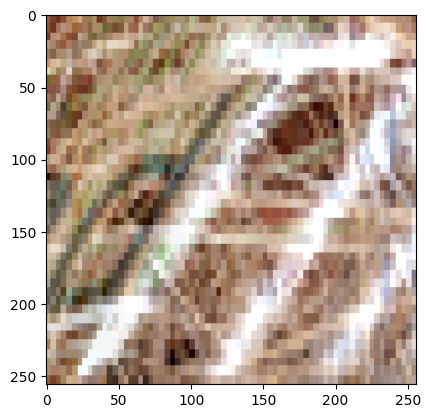

In [ ]:
h2 = t_dir.next()[0][1]
print(h2)
plt.imshow(h2)

In [ ]:
np.array_equal(h,h2)
diffs = h - h2
 
print(diffs)

ValueError: operands could not be broadcast together with shapes (224,224,3) (256,256,3) 

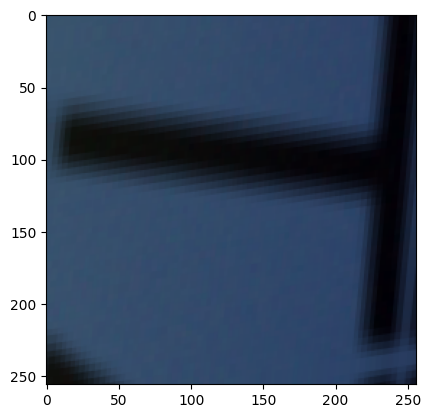

In [ ]:
plt.imshow(it.next()[0][0])

In [ ]:
k = tf.keras.utils.load_img('main_directory//Alex Brush//ant+hill_15.jpg_0_325.png')

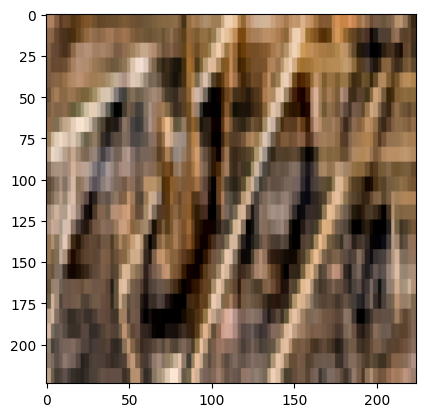

In [ ]:
plt.imshow(k)

In [ ]:
tf.keras.utils.save_img('main_directory//Alex Brush//ant+hill_15.jpg_0_325_copy.png',k)

In [ ]:
k = tf.keras.utils.load_img('main_directory//Alex Brush//ant+hill_15.jpg_0_325_copy.png')

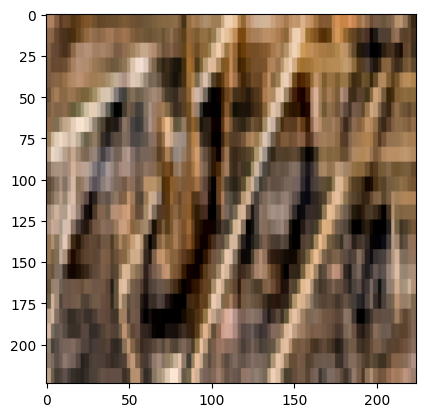

In [ ]:
plt.imshow(k)

In [ ]:
dg4 =  ImageDataGenerator(
     rescale=1/255, dtype='float32', target_size=(SIZE,SIZE)
     )
t4 = dg4.flow_from_directory('main_directory//Alex Brush//c/', shuffle=False, target_size=(SIZE,SIZE))

Found 1 images belonging to 1 classes.


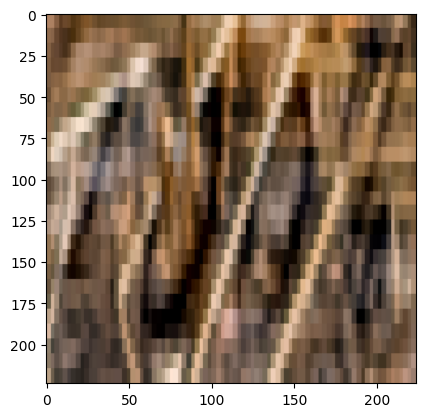

In [ ]:
plt.imshow(t4.next()[0][0])